In [1]:
import numpy as np
from scipy.optimize import curve_fit as cv
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import trackpy as tp
import pims
import matplotlib as mpl
import scipy.linalg as linalg
from PIL import Image

In [2]:
mpl.rcParams['figure.dpi'] = 200

In [3]:

def calculateNoise(I):
    show = 1
    if 1:
        # Delete background intensity
        In = I.flatten()           # Most Python functions don't work for a 2D array, so In has to be flattened.
        Im = np.sort(In)            # A sorted list of I, with background intensity.
        plt.figure()
        plt.title('Sorted intensity values')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid()
        plt.plot(Im)                # In this plot it can be seen that Im has been correctly sorted.
        med = np.median(Im)         # The median of IM can be calculated from the flattened sorted array Im.
        Imed = abs(I - med)


        # Calculate the noise intensity
        ilst = np.sort(Imed)                    # To create a sorted list of all present intensities.
        ilstflat = np.sort(ilst.flatten())      # ilst has to be flattened to find the max value with Python.
        ilst_t = ilst.transpose()
        ilstflat_t = np.sort(ilst_t.flatten())  # With the normal flatten function the rows are put bewelow eacht other, but we want to put the columns next to each other. Thus the transposed version of ilst is needed.
        b = len(Im)
        x = np.arange(1,b+1)
        Ihalf = (max(In)-med)/2
        # Ihalf=max(ilstflat)/2

        # Make sure that the flattened ilst is also sorted, otherwise the wrong index is found.
        #xIhalf_value = list(filter(lambda i: i > Ihalf, ilstflat_t))[0]         # This function gives the first value where ilst > Ihalf. With this value it can be checked if the position calculated in the next line is correct.
        xIhalf = np.where(ilstflat_t>Ihalf)[0][0]# Here the position of the first index with a value bigger than Ihalf is found.

        range_up=int(np.floor(b/2))
        coeff1= np.polyfit(x[0:range_up], ilstflat_t[0:range_up],1)
        coeff2 = np.polyfit(x[int(xIhalf):b], ilstflat_t[int(xIhalf):b], 1)     # Makes a linear fit to the highest half of all intensities in 'ilist'.
        if show:
            plt.figure()
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Noise intensity')
            plt.grid()
            plt.plot(x,np.sort(ilstflat_t),'b-')

        # The rightmost intersection is the chosen noise intensity which will be removed from all images.
        fit1 = np.polyval(coeff1,x)                                     # Returns an array of all values of the fitted line for every x coordinate.
        fit2 = np.polyval(coeff2,x)
        xcross=round((coeff1[1]-coeff2[1])/(coeff2[0]-coeff1[0]))
        ycross= np.polyval(coeff1,xcross)
        fit=np.concatenate([fit1[0:int(xcross-1)],fit2[int(xcross-1):]])
        if show:
            plt.plot(x,np.sort(ilstflat_t),'b-', x,fit,'r'), plt.ylim([0,max(ilstflat)])
        scale=max(x)/max(ilstflat)
        dist=np.sqrt((x-xcross)**2+(ycross-ilstflat_t*scale)**2)        # Calculates the difference between the true intensities and the values of crossing fitted lines.
        xmindist = np.argmin(dist)             # Calculates the x value of the rightmost intersection of the fitted line and the curve of all true intensities.
        threshold=ilstflat_t[(xmindist-1)]+np.std(ilst)                 # Calculates the intensity, which belongs to the above calculated x value. This equals the intensity of the noise which should be delete.
        if show:
            plt.plot(x,np.sort(ilstflat_t),'b-', x,fit,'k', xcross,ycross,'kx', xmindist, ilstflat_t[xmindist],'mo', [0,max(x)],[threshold,threshold],'r')
        return threshold

In [4]:
from os import listdir
from os.path import isfile, join

mypath = "..\\Matlab\\Trap"

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

only_tif_files = [f for f in onlyfiles if ".mat" not in f]

cleaned_labels = []

for i in range(0,len(only_tif_files)):                # /-- 2 for bead, 1 for trap
    cleaned_labels.append(only_tif_files[i].split(' ')[1])

print(onlyfiles)
print(only_tif_files)
print(cleaned_labels)

['trap 0 mW_0.mat', 'trap 0 mW_0.tif', 'trap 10 mW_0.mat', 'trap 10 mW_0.tif', 'trap 20 mW_0.mat', 'trap 20 mW_0.tif', 'trap 30 mW_0.mat', 'trap 30 mW_0.tif', 'trap 40 mW_0.mat', 'trap 40 mW_0.tif', 'trap 5 mW_0.mat', 'trap 5 mW_0.tif']
['trap 0 mW_0.tif', 'trap 10 mW_0.tif', 'trap 20 mW_0.tif', 'trap 30 mW_0.tif', 'trap 40 mW_0.tif', 'trap 5 mW_0.tif']
['0', '10', '20', '30', '40', '5']


In [5]:
k_b = 1.38*1e-23
T = 293
l_pixel = 4.68*1e-8
show = 0


In [6]:

def k_trap(x):  
       # replace nans by average
    x_ = np.where(np.isnan(x), np.nanmean(x), x)
    
       # Calculate variance and covariance
    var_x = np.sum((x_- np.mean(x_))**2)/(len(x_)+1)
    
    k_trap = k_b*T/(var_x)*1e3
    return k_trap

    
def ellipse_calc(x,y):  
       # replace nans by average
    x_ = np.where(np.isnan(x), np.nanmean(x), x)
    y_ = np.where(np.isnan(y), np.nanmean(y), y)
    
       # Calculate variance and covariance
    var_x = np.sum((x_-np.mean(x_))**2)/(len(x)+1)
    var_y = np.sum((y_-np.mean(y_))**2)/(len(y)+1)
    cov = np.sum((x_-np.mean(x_))*(y_-np.mean(y_))/(len(x_)+1))
    
    cov_matrix = np.asarray([[var_x, cov],[cov,var_y]])
    evals,evecs = linalg.eig(cov_matrix)
    evecs_ = evals*evecs
    #plt.plot(x,y, linestyle='none',marker='x',zorder=1)
    #plt.quiver(np.nanmean(x),np.nanmean(y), -evecs_[1,:],-evecs_[0,:],zorder=2, units='xy', scale=1, width=1e-8, headwidth=4)

    
    a = np.max(evals)
    b = np.min(evals)
    print(a)
    print(b)
    index_a = np.where(evals == a)[0]
    theta = np.arctan(evecs[0,index_a]/evecs[1,index_a])
    print('theta =', theta)
    return a,b,theta

def trap_calc(a,b,theta, theta_i):
    ''' Use function to calculate trap constant in arbitrary direction using the covariance ellipse.
    returns trap constant in any arbitrary direction in pN/nm
    a = length of semi-major axis of covariance ellipse
    b = length of semi-minor axis of covariance ellipse
    theta = angle of semi-major with respect to the x-axis in radians
    theta_i = angle of any arbitrary direction with respect to the x-axis in radians  '''
    
    phi = theta_i - theta  # relative angle between major axis and arbitrary direction
    r = a*b/(np.sqrt(b*np.cos(phi))**2 + (a*np.sin(phi))**2)
    k_trap = k_b*T/(r)*1e3   #pN/nM
    return k_trap                  

Frame 999: 1 features
(3.880393555469783e-13+0j)
(9.940929211613322e-14+0j)
theta = [-1.41239619]


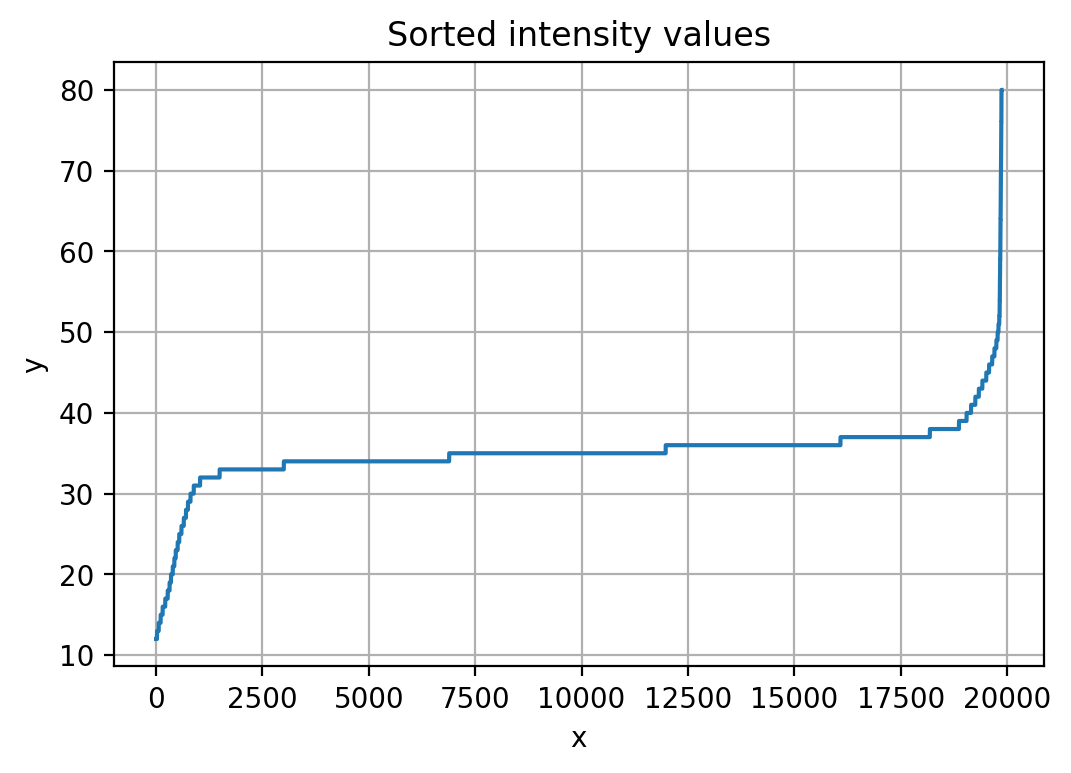

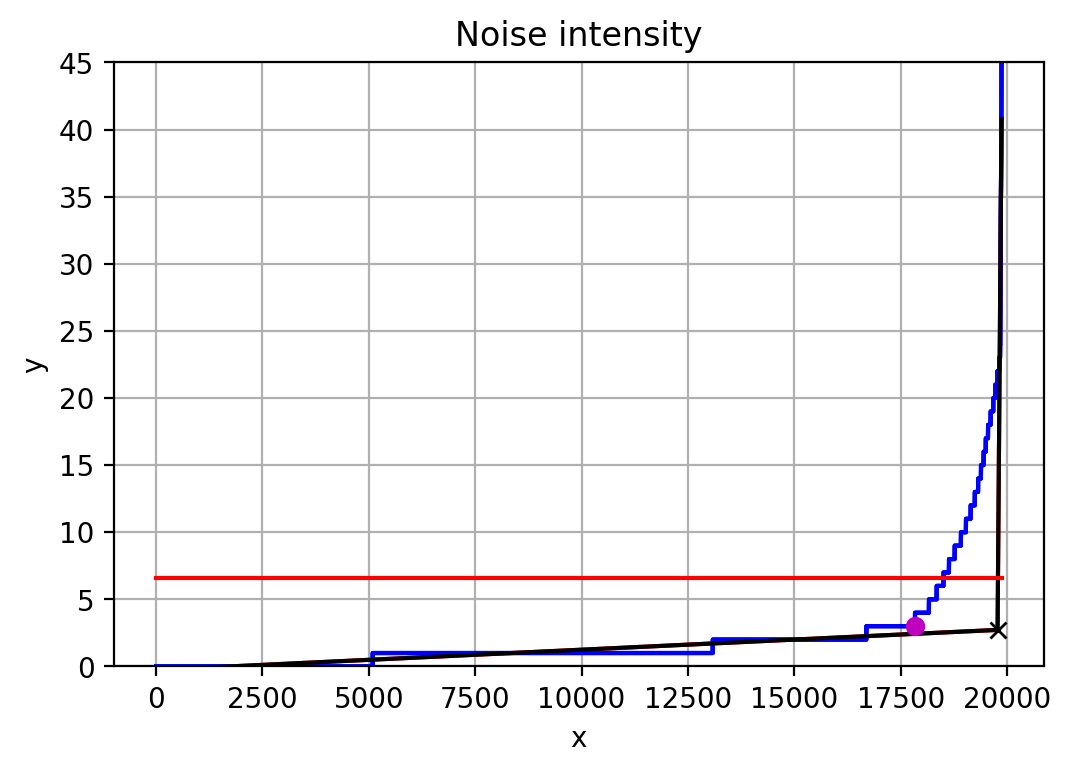

In [8]:
frames = pims.open("bead 2 10 mw_0.tif")     # import file
threshold = calculateNoise(frames[0])   # Calculate noise threshold of first frame
f = tp.batch(frames,15, minmass = 100, maxsize=10, threshold=threshold, topn=1)    # Find bead location for all frames
X = f['x']
Y = f['y']

a,b,theta = ellipse_calc(X*l_pixel,Y*l_pixel)
k_x = trap_calc(a,b,theta,0)
k_trap_x = k_trap(X*l_pixel)
k_trap_y = k_trap(Y*l_pixel)

Frame 999: 1 features
(7.586580316600512e-15+0j)
(2.8930634444134092e-15+0j)
theta = [-0.43949673]


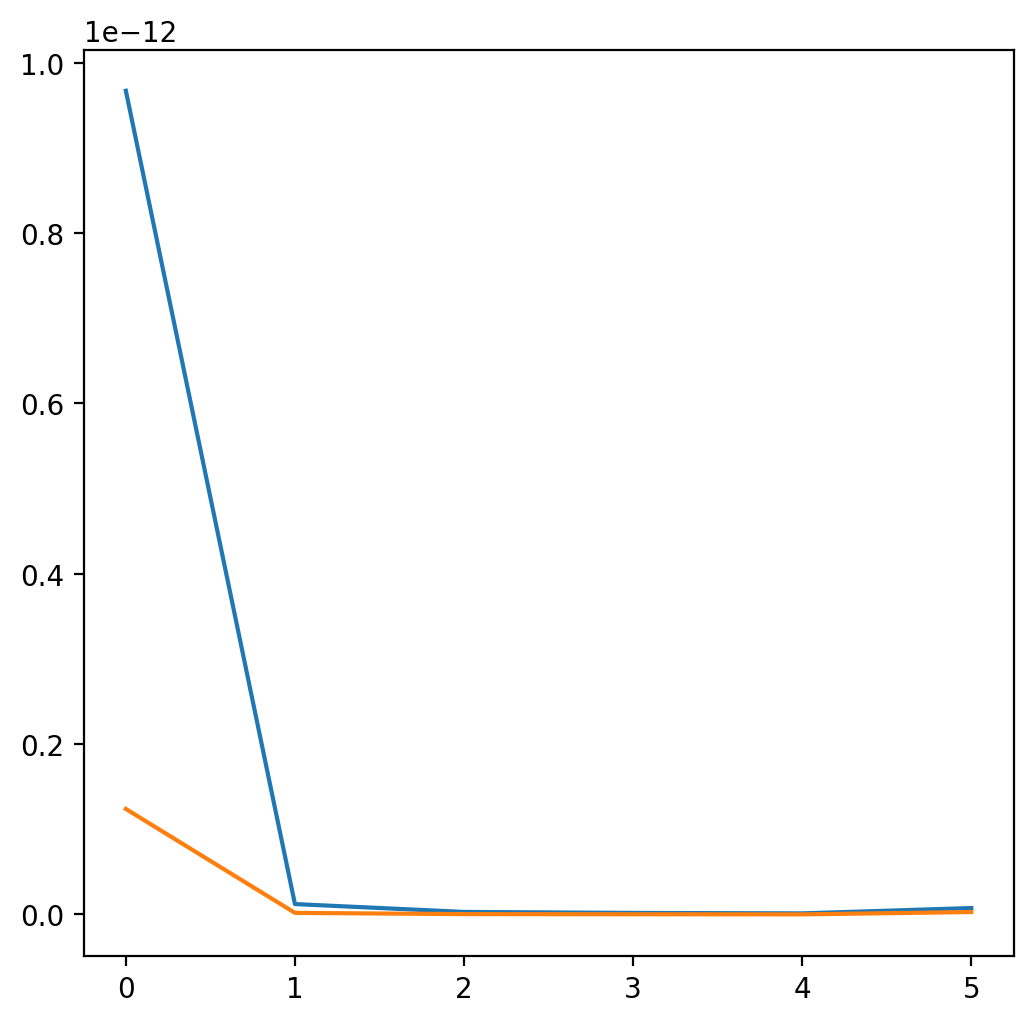

In [9]:
plt.close()
ax_num = len(only_tif_files)

fig, ax = plt.subplots(figsize=(6,6), dpi=200)

a_array = np.zeros(len(only_tif_files))
b_array = np.zeros(len(only_tif_files))
t_array = np.zeros(len(only_tif_files))
X = np.zeros(len(only_tif_files), dtype='object')
Y = np.zeros(len(only_tif_files), dtype='object')


print(a)

for i in range(0,len(only_tif_files)):
    print(str(mypath+'\\'+only_tif_files[i]))
    frames = pims.open(str(mypath+'\\'+only_tif_files[i]))
    f = tp.batch(frames,15, minmass = 100, maxsize=10, threshold=threshold, topn=1)
    X[i] = f['x']
    Y[i] = f['y']
    a_array[i], b_array[i], t_array[i] = ellipse_calc(X[i]*l_pixel,Y[i]*l_pixel)

ax = plt.plot(a_array, label='a')
ax = plt.plot(b_array, label='b')
plt.show()







In [15]:
%matplotlib inline

In [11]:
def function_to_fit(x,a,b):
    return a*np.exp(-x*b)

a 9.671122214472635e-13 0.9644880933833682
b 1.2393666918559816e-13 0.745489756462456


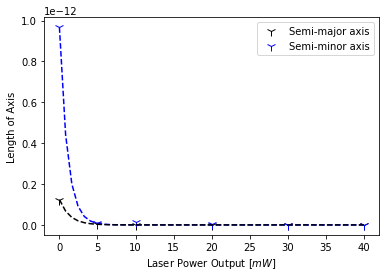

In [12]:
power = np.array( [int(f) for f in cleaned_labels] )

param_a, param_unc = cv(function_to_fit, power, a_array, p0=[5.6e-13, 0.175])
param_b, param_unc = cv(function_to_fit, power, b_array)

x_range = np.linspace(0,40)

b_fit = function_to_fit(x_range, *param_b)
a_fit = function_to_fit(x_range, *param_a)

print("a" , *param_a)
print("b" , *param_b)

plt.plot(power, b_array, label=r'Semi-major axis', marker='1', markersize=10, linestyle='none', color='black')
plt.plot(power, a_array, label=r'Semi-minor axis', marker='1', markersize=10, linestyle='none', color='blue')
plt.plot(x_range, a_fit, color='blue', linestyle='--')
plt.plot(x_range, b_fit, color='black', linestyle='--')
plt.xlabel(r'Laser Power Output [$mW$]')
plt.ylabel(r'Length of Axis')
plt.legend()
plt.savefig('axis.png', dpi=200)

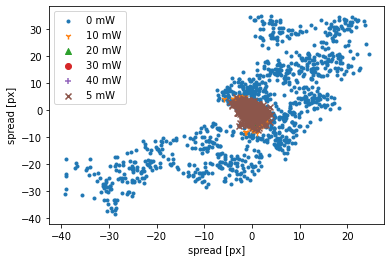

In [17]:
markers= ['.','1','^','o','+','x','s']

for i in range(0,len(only_tif_files)):
    color = i/(len(only_tif_files)+1)
    r= g= b= color
    plt.scatter(X[i]-np.nanmean(X[i]),Y[i]-np.nanmean(Y[i]), label=cleaned_labels[i]+' mW', marker=markers[i])
plt.xlabel('spread [px]')
plt.ylabel('spread [px]')
plt.legend()
plt.savefig('spread.png', dpi=200)

In [14]:
%matplotlib notebook

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
line, = ax[0].plot(0, 0, marker="1", color="black")
txt = ax[0].text(0,0,'o', color='white')
ani_im = ax[0].imshow(frames[0], origin='lower')

ax[0].set_ylim(0,np.shape(frames)[1])
ax[0].set_xlim(0,np.shape(frames)[2])

linex, = ax[1].plot(0,0, label='y position')
liney, = ax[1].plot(0,0, label='x position')

ax[1].set_xlim(0,np.shape(frames)[0])
ax[1].set_ylim(int(np.min((X,Y))-1), int(np.max((X,Y)))+1)

ax[1].legend()

def animation_frame(iterant):
    ani_im.set_array(frames[iterant])

    #fig.set_title(str(iterant))

    line.set_xdata(X[iterant])
    line.set_ydata(Y[iterant])
#     txt.set_position((Yest[iterant],Xest[iterant]+10))
#     txt.set_text( ( str(Xest[iterant])[0:3],str(Yest[iterant])[0:3] ) )
#     txt.set_color(color[iterant])

    linex.set_xdata(np.arange(iterant))
    liney.set_xdata(np.arange(iterant))
    linex.set_ydata(X[0:iterant])
    liney.set_ydata(Y[0:iterant])
    return [line,linex,liney]

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(np.shape(frames)[0]), interval=10)
plt.show()

<IPython.core.display.Javascript object>

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().